# Исследование сервиса аренды самокатов GoFast

**Цель**: в ходе нашего исследования мы проанализируем данные о пользователях исходного сервиса из нескольких городов, а также о совершаемых ими поездках. Также в ходе исследования мы проверим некоторые предложенные гипотезы, которые могут помочь бизнесу вырасти. 
В качестве исходных данных используем файлы users_go.csv, rides_go.csv, subscriptions_go.csv

Структура этих данных следующая:
**users_go.csv**
*user_id*	уникальный идентификатор пользователя
*name*	имя пользователя
*age*	возраст
*city*	город
*subscription_type*	тип подписки (free, ultra)

**rides_go.csv**
*user_id*	уникальный идентификатор пользователя
*distance*	расстояние, которое пользователь проехал в текущей сессии (в метрах)
*duration*	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
*date*	дата совершения поездки

**subscriptions_go.csv**
*subscription_type*	тип подписки
*minute_price*	стоимость одной минуты поездки по данной подписке
*start_ride_price*	стоимость начала поездки
*subscription_fee*	стоимость ежемесячного платежа

В ходе работы - проанализируем исходные данные, проведем их предварительную обработку, проанализируем частоту встречаемости городов, соотношение пользователей с подпиской и без, их возраст, среднее расстояние за поездку и их продолжительность. проведем также расчеты ежемесячной выручки для каждого пользователя. Сформулируем и проверим также ряд гипотез, которые потенциально смогут увеличить количество пользователей с подпиской.

# 1. Загрузка данных

Проведем первичный анализ исходных данных о пользователях, поездках и типах подписок. 

In [1]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy.stats import binom, norm


## 1.1 Считывание данных 

Считаем соответсвующие данные из предложенных файлов. 

In [2]:
#Импортируем библиотеку pandas

#Считываем csv файлы с данными и сохраняем их в соответсвующие датафреймы
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_users = pd.read_csv('users_go.csv')  
    data_rides = pd.read_csv('rides_go.csv')
    data_subscriptions = pd.read_csv('subscriptions_go.csv')

## 1.2 Общая информация о считанных данных

Проанализируем общую информацию об имеющихся данных.

In [3]:
#Выводим первые строчки данных с пользователями 
data_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
#Выводим первые строчки данных с поездками
data_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
#Выводим первые строчки с данными ои\ подписках
data_subscriptions.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
#Выводим общую информацию о пользователях
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
#Выводим общую информацию о поездках 
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
#Выводим общую информацию о подписках
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод**: из полученного видно, что в данных отсутствуют пропуски, но в некоторых данных лучше произвести замену их типа. 

# 2. Предобработка данных

Для дальнейшей работы произведем предобработку данных. 

## 2.1 Преобразование типов данных

Данные о дате совершения поездки имеют неподходящий для дальнейшего тип object. Приведем эти данные к типу datetime.

In [9]:
#Приведем столбец data из датафрейма о поездках к типу datetime 
data_rides['date'] = pd.to_datetime(
    data_rides['date'], format='%Y-%m-%d'
)

## 2.2 Создание нового столбца с номером месяца

Для проведения дальшейшего анализа данных выделим новый столбец, в котором укажем месяц, в котором была совершена поездка. 

In [10]:
#Создадим новый столбец в данных о поездках с номером месяца поездка

data_rides['month'] = data_rides['date'].dt.month


## 2.3 Анализ пропущенных значений и дубликатов 

Проведем анализ пропущенных значений и дубликатов в данных. 

In [11]:
#Определим число пропущенных значений для  пользователей
data_users.isna().sum()


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
#Определим число пропущенных значений для поездок
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
#Определим число пропущенных значений для подписок
data_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [14]:
#Определим количество дубликатов для пользователей
data_users.duplicated().sum()

31

In [15]:
#Удалим имеющиеся дубликаты для пользователей и проверим число дубликатов
data_users = data_users.drop_duplicates().reset_index(drop=True)
data_users.duplicated().sum()

0

In [16]:
#Определим количество дубликатов для поездок
data_rides.duplicated().sum()

0

In [17]:
#Определим количество дубликатов для подписок 
data_subscriptions.duplicated().sum()

0

In [18]:
#Проанализируем столбец name на наличие неявных дубликатов 
data_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [19]:
#Проанализируем столбец city на наличие неявных дубликатов 
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Вывод**: Среди представленных данных были обнаружены и удалены явные дубликаты. Неявных дубликатов для данных имен и названий населенных пунктов обнаружено не было. 

# 3. Исследовательский анализ данных

Пронализируем общую информацию о пользователях и поездках.

## 3.1 Частота встречаемости городов

In [20]:
#Выведем общую информацию о пользователях
data_users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


In [21]:
#Построим таблицу по встречаемости различных городов
city_group = data_users.pivot_table(index = 'city', values = 'user_id', aggfunc='count')
city_group

,user_id
city,
Екатеринбург,204
Краснодар,193
Москва,168
Омск,183
Пятигорск,219
Ростов-на-Дону,198
Сочи,189
Тюмень,180


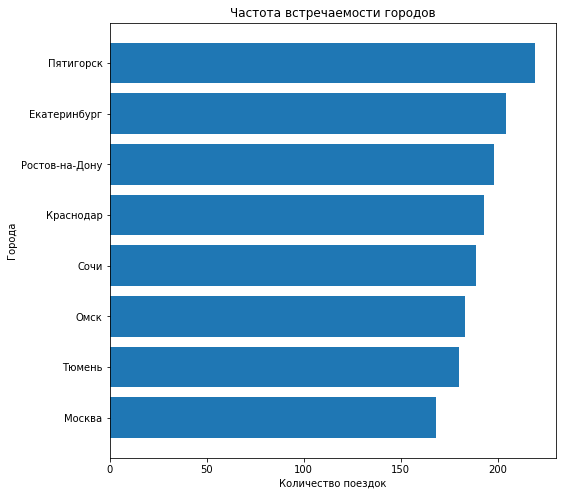

In [22]:
#Построим гистограмму для частоты встречаемости разных городов
city_group = city_group.sort_values(by = 'user_id')
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(city_group.index, city_group['user_id'])
plt.ylabel('Города')
plt.title('Частота встречаемости городов')
plt.xlabel('Количество поездок')
plt.show()


**Вывод**: из гистограммы видно, что чаще всего встречается город Пятигорск, а реже всего встречается город Москва. 
Количество упоминаний каждого из городов находится в диапазоне от 150 до 250 раз. Также из общих данных о пользователях можно определить, что средний возраст пользователей 25 лет.

## 3.2 Соотношение пользователей с подпиской и без подписки 

In [23]:
#Расчитаем количество разных типов подписок
free_perc = data_users.loc[data_users['subscription_type']=='free']['user_id'].count()
ultra_perc = data_users.loc[data_users['subscription_type']=='ultra']['user_id'].count()

In [24]:
print('Количество пользователей без подписки составляет', free_perc*100/(ultra_perc+free_perc ))

Количество пользователей без подписки составляет 54.43285528031291


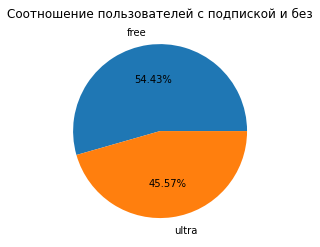

In [25]:
#Построим гистограмму для соотношения разных типов подписок 
data_users_sub = data_users.pivot_table(index='subscription_type', values ='user_id', aggfunc='count')
plt.title('Соотношение пользователей с подпиской и без')
plt.pie(data_users_sub['user_id'], labels = data_users_sub.index , labeldistance=1.15,  autopct=lambda p:f'{p:.2f}%')
plt.show()

**Вывод**: из полученных данных делаем вывод, что количество людей без подписок незначительно превосходит людей с подписками.

## 3.3 Возраст пользователей 

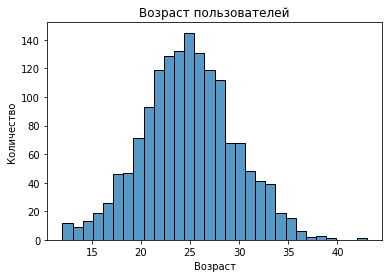

In [26]:
#Построим гистограму распределения возрастов пользователей
sns.histplot(data= data_users, x="age")
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

**Вывод**: из гистограммы видно, что возраст пользователей в основном находится в диапазоне от 10 до 40 лет. Наибольшую долю составлют молодые - от 20 до 30 лет. Распределение имеет практически нормальный вид со средним значением около 26 лет. 

## 3.4 Расстояние, которое пользователь преодолел за одну поездку

In [27]:
#Выведем общую информацию о растояниях
data_rides.describe()


,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


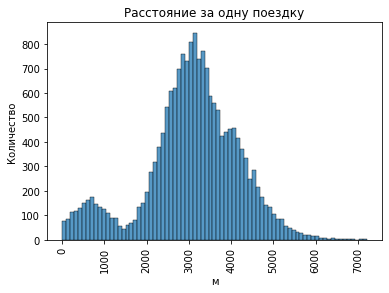

In [28]:
#Построим гистограму распределения расстояний за одну поездку
sns.histplot(data= data_rides, x="distance")
plt.xticks(rotation=90)
plt.title('Расстояние за одну поездку')
plt.xlabel('м')
plt.ylabel('Количество')
plt.show()

**Вывод**: из полученных данных можно отметить следующее - расстояние за одну поездку практические не превышают 6000 м.  Среднее расстояние за поездку составляет 3 км. Поездки Можно разделить на два типа - коротки с средними расстояними порядка 600 метров и длительные - порядка 3 км.

## 3.5 Продолжительность поездок

In [29]:
#Определим основные статистические характеристи для продолжительности поездок
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

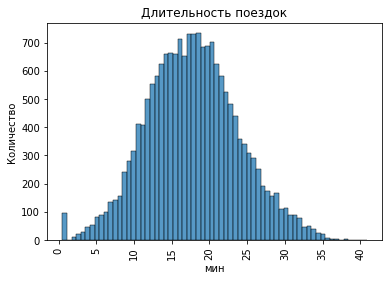

In [30]:
#Построим гистограму распределения продолжительности поездок 
sns.histplot(data= data_rides, x='duration')
plt.xticks(rotation=90)
plt.title('Длительность поездок')
plt.xlabel('мин')
plt.ylabel('Количество')
plt.show()

**Вывод**: поездки не превышают по длительности 40 минут, большая часть поездок происходит в интервали от 10 до 25 минут. Среднее значение времени поездки - 17.8 минут.

**Общий вывод**:
- Самый часто встречаемый город Пятигорск
- Пользователей без подписки на 4 процента больше, чем с подпиской 
- Распределение возраста пользователей - нормальное со средним равным 26
- Среднее расстояние за поездку около 3 км
- Средняя продолжительность поездок около 18 минут

# 4. Объединение данных

Для дальнейшего анализа создадим вспомогательные датафреймы. 

## 4.1 Создание общего датафрейма

In [31]:
#Объединим данные о пользователях, поездках и подписках в один датафрейм
data = data_users.merge(data_rides, on='user_id')
data = data.merge(data_subscriptions, on='subscription_type')

In [32]:
#Проверим размерности полученных датафреймов
display(data_users.shape[0])
display(data_rides.shape[0])
display(data_subscriptions.shape[0])
data.shape[0]

1534

18068

2

18068

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


**Вывод**: Пропуски в итоговых данных отсутсвуют

## 4.2 Создание дополнительных датафреймов

In [34]:
#Создадим датайфрем с данными пользователей без подписки
data_free = data.loc[data['subscription_type']=='free']
data_free.reset_index(drop=True)
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [35]:
#Создадим датайфрем с данными пользователей c подпиской
data_ultra = data.loc[data['subscription_type']=='ultra']
data_ultra.reset_index(drop=True)
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [36]:
# Код ревьюера
display(data.shape[0])
display(data_free.shape[0])
data_ultra.shape[0]

18068

11568

6500

## 4.3 Визуализация данных пользователей с подпиской и без

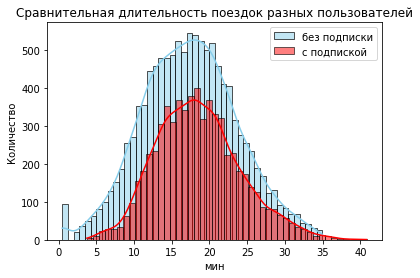

In [37]:
#Построим гистограммы для длительности поездок пользователей с подпиской и без
sns.histplot(data=data_free, x="duration", color="skyblue", label="без подписки", kde=True)
sns.histplot(data=data_ultra, x="duration", color="red", label="с подпиской", kde=True)
plt.title('Сравнительная длительность поездок разных пользователей')
plt.xlabel('мин')
plt.ylabel('Количество')
plt.legend() 
plt.show()

**Вывод**: Из графика видно, что пользователей с подпиской действительно меньше чем пользователей без подписки. Оба распределения длительности имеют вид похожий на нормальный, но центр для пользователей без подписки смещен немного влево относительно пользователей с подпиской. 

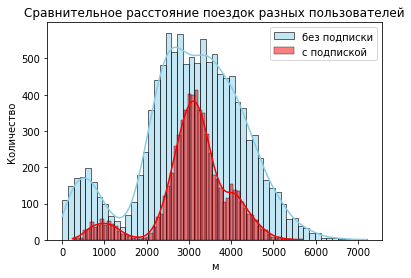

In [38]:
#Построим гистограммы для расстоянии поездок пользователей с подпиской и без
sns.histplot(data=data_free, x="distance", color="skyblue", label="без подписки", kde=True)
sns.histplot(data=data_ultra, x="distance", color="red", label="с подпиской", kde=True)
plt.title('Сравнительное расстояние поездок разных пользователей')
plt.xlabel('м')
plt.ylabel('Количество')
plt.legend() 
plt.show()

**Вывод**: Тут также видно, что пользователей без подписки больше, чем пользователей с подпиской. Распределения носят похожий вид с двумя выделеными "горбами". 

# 5. Подсчёт выручки

Проведем анализ по месяцам для выручки, расстояния  и суммарного времени.

## 5.1 Помесячные данные

In [39]:
#Создадим датайфрейм с суммарным расстоянием, колиечством поездок и суммарным временем для каждого пользователя за месяц
#Округлим значения длительности поездок
data['duration'] = np.ceil(data['duration'])

#Сгруппируем данные по пользователям и месяцам, вычислим общее расстояние и время, а также количество поездок. Укажем в таблице также тип подписки
data_u = data.pivot_table(index = ['user_id','subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee', 'month'], values = ['distance', 'duration'], aggfunc = {'distance':sum, 'duration':sum, 'user_id':len }) 
data_u.rename(columns = {'user_id':'rides', 'distance':'distance_per_month', 'duration':'duration_per_month'}, inplace = True )
data_u

distance_per_month  \
user_id subscription_type minute_price start_ride_price subscription_fee month                       
1       ultra             6            0                199              1             7027.511294   
                                                                         4              754.159807   
                                                                         8             6723.470560   
                                                                         10            5809.911100   
                                                                         11            7003.499363   
...                                                                                            ...   
1534    free              8            50               0                6             3409.468534   
                                                                         8             7622.453034   
                                                                         9             4928.173852   
                                                                         11           13350.015305   
                                                                         12            2371.711192   

                                                                                duration_per_month  \
user_id subscription_type minute_price start_ride_price subscription_fee month                       
1       ultra             6            0                199              1                    42.0   
                                                                         4                     7.0   
                                                                         8                    46.0   
                                                                         10                   32.0   
                                                                         11                   56.0   
...                                                                                            ...   
1534    free              8            50               0                6                    26.0   
                                                                         8                    48.0   
                                                                         9                    23.0   
                                                                         11                   78.0   
                                                                         12                   16.0   

                                                                                rides  
user_id subscription_type minute_price start_ride_price subscription_fee month         
1       ultra             6            0                199              1          2  
                                                                         4          1  
                                                                         8          2  
                                                                         10         2  
                                                                         11         3  
...                                                                               ...  
1534    free              8            50               0                6          2  
                                                                         8          2  
                                                                         9          1  
                                                                         11         4  
                                                                         12         1  

[11331 rows x 3 columns]

## 5.2 Помесячная выручка

In [40]:
#Рассчитаем помесячную выручку
data_u['total_income'] = ( data_u['rides']*data_u['rides'].index.get_level_values(3) 
                          + data_u['duration_per_month']*data_u['duration_per_month'].index.get_level_values(2)
                          + data_u['rides'].index.get_level_values(4))
data_u

distance_per_month  \
user_id subscription_type minute_price start_ride_price subscription_fee month                       
1       ultra             6            0                199              1             7027.511294   
                                                                         4              754.159807   
                                                                         8             6723.470560   
                                                                         10            5809.911100   
                                                                         11            7003.499363   
...                                                                                            ...   
1534    free              8            50               0                6             3409.468534   
                                                                         8             7622.453034   
                                                                         9             4928.173852   
                                                                         11           13350.015305   
                                                                         12            2371.711192   

                                                                                duration_per_month  \
user_id subscription_type minute_price start_ride_price subscription_fee month                       
1       ultra             6            0                199              1                    42.0   
                                                                         4                     7.0   
                                                                         8                    46.0   
                                                                         10                   32.0   
                                                                         11                   56.0   
...                                                                                            ...   
1534    free              8            50               0                6                    26.0   
                                                                         8                    48.0   
                                                                         9                    23.0   
                                                                         11                   78.0   
                                                                         12                   16.0   

                                                                                rides  \
user_id subscription_type minute_price start_ride_price subscription_fee month          
1       ultra             6            0                199              1          2   
                                                                         4          1   
                                                                         8          2   
                                                                         10         2   
                                                                         11         3   
...                                                                               ...   
1534    free              8            50               0                6          2   
                                                                         8          2   
                                                                         9          1   
                                                                         11         4   
                                                                         12         1   

                                                                                total_income  
user_id subscription_type minute_price start_ride_price subscription_fee month                
1       ultra             6            0                199              1    

**Вывод**: была вычислена помесячная выручка для каждого пользователя.

In [51]:
# Код ревьюера
data_rev = data_u.copy()
data_rev.reset_index(inplace = True)
data_rev.groupby('subscription_type')['total_income'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: total_income, dtype: float64

## 6. Проверка гипотез

Проверим некоторые статистические гипотезы, которые могут увеличить количество пользователей с подпиской. 

## 6.1 Время поездок у разных пользователей


**Нулевая гипотеза** - среднее время пользователей с подпиской и без подписки - одинаково.
**Альтернативная гипотеза** - среднее время пользователей с подпиской больше, чем пользователей без подписки.

In [41]:
#Проверяем гипотезу с помощью t-test

free_u = data_free['duration']
ultra_u = data_ultra['duration']
#Зададим уровень статистической значимости 
alpha = 0.05

#Вычисляем p-значение для односторонней гипотезы 
results = st.ttest_ind(free_u, ultra_u, alternative ='less')

print ('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу о равенстве среднего времени')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднего времени')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу о равенстве среднего времени


**Вывод**: есть основания полагать, что пользователи с подпиской тратят больше времени на поездки. 

## 6.2 Оптимальность расстояния поездок 

**Нулевая гипотеза**: Среднее расстояние поездки для пользователей равно 3130 метров.
**Альтернативная гипотеза**: Среднее расстояние поездки для пользователей больше 3130 метров. 

In [42]:
#Проверим гипотезу с помощью одностороннего t-test
recommended_value = 3130
alpha = 0.05

results = st.ttest_1samp(
            data_ultra['distance'],
            recommended_value,
            alternative='greater')
print('p-значение:', results.pvalue)

if (results.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')



p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод** - нельзя утверждать, что проезжаемое пользователями с подпиской расстояние за одну поездку не превышает 3130 метров. Это говорит о том, что в среднем самокат изнашивается не достаточно оптимально.

## 6.3 Помесячная выручка

**Нулевая гипотеза**: Средняя помесячная выручка от пользователей с подпиской равна такой же выручке от пользователей без подписки. 
**Альтернативная гипотеза**: Средняя помесячная выручка от пользователей без подписки меньше, чем от пользователей с подпиской. 

In [43]:
#Проверим гипотзу с помощью t-test
free = data_u['total_income'].loc[data_u.index.get_level_values(1)=='free']
ultra = data_u['total_income'].loc[data_u.index.get_level_values(1)=='ultra']
#Зададим уровень статистической значимости 
alpha = 0.05

#Вычисляем p-значение для односторонней гипотезы 
results = st.ttest_ind(free, ultra, alternative ='less')

print ('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу о равенстве ежемесячных выручек')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве ежемесячных выручек')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу о равенстве ежемесячных выручек


**Вывод**: можно сделать вывод, что ежемесячная выручка для пользователей с подпиской значимо выше, чем для пользователей без подписки. 

## 6.4 Обновление сервера

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.
Для проверки этой гипотезы воспользуемся вользуемся гипотезой о равенстве средних для зависимых (парных) выборок и проведем соответсвующий t-test при помощи функции scipy.stats.ttest_rel().

**Общие выводы**:
- Есть основания полагать, что пользователи с подпиской тратят больше времени на поездки. 
- Нельзя утверждать, что проезжаемое пользователями с подпиской расстояние за одну поездку не превышает 3130 метров.
- Можно сделать вывод, что ежемесячная выручка для пользователей с подпиской значимо выше, чем для пользователей без подписки. 

# 7. Распределения 

## 7.1 Проведение акции 

Нужно провести акцию, с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить подписку. 

Выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Определим, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. 

Продление или не продление подписки - это испытание бернули с вероятностью успеха p = 0.1. Количество успешных исходов данного испытания описывается биномиальным распределением. 

Подберем необходимые параметры этого распределение. Т.е. нам необходимо, чтобы вероятность того, что менее 100 клиентов продлят подписку равнялась 5%. 

In [44]:
#Зададим начальное значение клиентов и вероятность успеха
n, p = 100, 0.1

#Определим минимум клиентов для успешности испытания
k = 100

#Вычислим при каком значении n необходимая вероятность станет примерно равной 0.05
while binom.cdf(k, n, p) > 0.05:
    n = n + 1

print('Подобранное число клиентов равняется ', n)
print('В этом случае вероятность того, что количество менее 100 клиентов продлять подписку равняется', round (binom.cdf(k, n, p),4)) 

Подобранное число клиентов равняется  1172
В этом случае вероятность того, что количество менее 100 клиентов продлять подписку равняется 0.0495


**Вывод**: для того, чтобы вероятность того, что менее 100 клиентов после проведения акции продлят подписку равнялась примерно 5% необхдоимо провести испытание с 1172 клиентами. В этом случае вероятность будет равнятся 0.0495

## 7.2 Рекламные уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399.5 тыс. пользователей. 

In [45]:
#Зафиксируем параметры данного биномиального распределения 
n = 1000000
p = 0.4
x = 399500
#Параметры этого распределения
mean = binom(n, p).mean()
std = binom(n,p).std()
print('Среднее значение', mean)
print('Стандартное отклонение', std)

Среднее значение 400000.0
Стандартное отклонение 489.89794855663564


Проверим можно ли аппроксимировать данное распределение нормальным. 

In [46]:
#Определим границы промежутка от математического ожидания плюс-минус три стандартных отклонения
a , b = mean - 3*std, mean+3*std
print('Левая граница', a)
print('Правая граница', b)

Левая граница 398530.3061543301
Правая граница 401469.6938456699


Полученные границы попадают в промежуток [0, 1000000], следовательное данное распределение можно аппроксимировать нормальным. 

In [47]:
#Зададим нормальное распределение с математическим ожиданием и стандартным отклонением биномиального распределения 
mu = mean
sigma = std
distr = st.norm(mu, sigma)

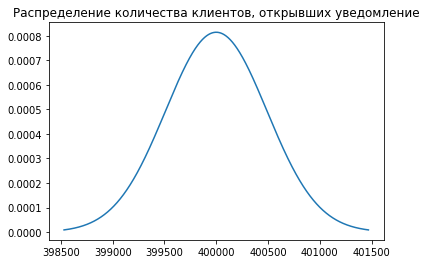

In [48]:
#Визуализируем нормальное распределение 
x = np.arange (a, b, 0.001)
plt.title('Распределение количества клиентов, открывших уведомление')


plt.plot (x, norm. pdf (x, mu, sigma))

In [49]:
#Расчитаем искомую вероятность того, что уведомление откроют не более 399.5 тыс. пользователей 
y = 399500
result = distr.cdf(y)
print(result)

0.15371708296369768


**Вывод**: количество клиентов, которые открывают присланные уведомления, может быть апроксимировано в виде нормального распределения. Вероятность того, что уведомление откроют не более 399.5 тыс. в данном испытании составляет 15%.

# Выводы:

В ходе проведения исследования были обработаны данные о пользователях и их поездках в приложении GoFast. 
На основе исследовательского анализа данных были сделаны следующие выводы: 
- Самый часто встречаемый город Пятигорск
- Пользователей без подписки на 4 процента больше, чем с подпиской 
- Распределение возраста пользователей - нормальное со средним равным 26
- Среднее расстояние за поездку около 3 км
- Средняя продолжительность поездок около 18 минут
Для проверки статистически гипотез представленные данные были агрегированы для анализа ежемесячной выручки от каждого пользователя. 
Были проверены несколько статистических гипотез и сделаны следующие выводы: 
- Есть основания полагать, что пользователи с подпиской тратят больше времени на поездки. 
- Нельзя утверждать, что проезжаемое пользователями с подпиской расстояние за одну поездку не превышает 3130 метров.
- Можно сделать вывод, что ежемесячная выручка для пользователей с подпиской значимо выше, чем для пользователей без подписки. 
Также в ходе исследования проанализированы следующие ситуации - проведение акции по с бесплатным промокодом и рассылка push-уведомлений. Сделаны следующие выводы:
- Вероятность того, что уведомление откроют не более 399.5 тыс. в данном испытании составляет 15%.
- Чтобы вероятность того, что менее 100 клиентов после проведения акции продлят подписку равнялась примерно 5% необхдоимо провести испытание с 1172 клиентами. В этом случае вероятность будет равнятся 0.0495

Таким образом, пользователи с подпиской являются более выгодными для компании - в среднем доход получаемых от них ежемясячно больше. Для привлечения новых клиентов с подписками достаточно эффективным будет проведение акции с бесплатными промокодами (на количестве клиентов более 1170). 